In [1]:
from koh import *
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle


In [22]:
def one_hot_encode_last_column(df):
    column = df.columns[-1]  # Get the last column name
    one_hot = pd.get_dummies(df[column], prefix=column, dtype=int)  # One-hot encode
    df = df.drop(columns=[column])  # Drop original column
    return pd.concat([df, one_hot], axis=1)

def scatter_with_categories(df):
    """
    Plots a scatter plot of x vs y, colored by category c.

    Parameters:
    df (pd.DataFrame): DataFrame with columns 'x', 'y', and 'c'
    """
    if not {'x', 'y', 'c'}.issubset(df.columns):
        raise ValueError("DataFrame must contain 'x', 'y', and 'c' columns")

    # Use seaborn color palette for consistent coloring
    unique_categories = sorted(df['c'].unique())
    from builtins import len
    palette = sns.color_palette('tab10', len(unique_categories))
    color_map = dict(zip(unique_categories, palette))

    # Plot each category separately for a legend
    plt.figure(figsize=(8, 6))
    for category in unique_categories:
        subset = df[df['c'] == category]
        plt.scatter(subset['x'], subset['y'],
                    color=color_map[category],
                    label=f"Category {category}", alpha=0.7)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Scatter Plot Colored by Category')
    plt.legend(title='Category')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    from builtins import len



def visualise_kohonen(closest_data, closest_data2):
    h = closest_data.shape[0]
    w = closest_data.shape[1]
    category_colors = [
        "#e41a1c",  # Red
        "#377eb8",  # Blue
        "#4daf4a",  # Green
        "#984ea3",  # Purple
        "#ff7f00",  # Orange
        "#ffff33",  # Yellow
        "#a65628",  # Brown
        "#f781bf",  # Pink
        "#999999",  # Gray
        "#66c2a5",  # Turquoise
        "#fc8d62",  # Salmon
        "#8da0cb",  # Lavender
        "#e78ac3",  # Light pink
        "#a6d854",  # Lime green
        "#ffd92f",  # Bright yellow
        "#e5c494",  # Beige
        "#b3b3b3",  # Light gray
        "#1f78b4",  # Steel blue
        "#33a02c",  # Dark green
        "#fb9a99",  # Light red
    ]

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(0, w)
    ax.set_ylim(0, h)
    ax.set_aspect('equal')
    ax.axis('off')

    max_circles_per_row = 5
    circle_radius = 0.07
    for x in range(20):
        for y in range(20):
            counts = closest_data[y, x]
            majority_color = category_colors[closest_data2[y, x]]

            # Draw the neuron square
            neuron = Rectangle((x, h - 1 - y), 1, 1, color=majority_color, ec='black', lw=0.5, alpha=1)
            ax.add_patch(neuron)
            total = counts.sum()
            if total == 0:
                continue  # Nothing to draw


            tot_count = 0
            for cat_idx, count in enumerate(counts):
                for n in range(count):
                    # Layout: rows of max_circles_per_row
                    row = tot_count // max_circles_per_row
                    col = tot_count % max_circles_per_row

                    spacing = 1 / max_circles_per_row
                    cx = x + 0.10 + col * spacing
                    cy = h - 1 - y + 0.85 - row * spacing

                    if cy < h - 1 - y:  # Stay inside the square
                        break

                    circ = Circle(
                        (cx, cy),
                        radius=circle_radius,
                        color=category_colors[cat_idx],
                        ec='black',
                        lw=0.25
                    )
                    ax.add_patch(circ)
                    tot_count += 1

    plt.tight_layout()
    plt.show()

def get_closest_data(weights, labeled):
    #we assume categories are coded starting from 0
    n_cat = int(np.max(labeled[:,-1])) + 1
    h, w, d = weights.shape
    closest_data = np.zeros((h, w, n_cat), dtype=int)
    dims = labeled.shape[1] - 1
    for labeled_row in labeled:
        coords = labeled_row[:dims]
        cat = int(labeled_row[dims])
        #get closest nauron coords
        min_dist = float('inf')
        min_coords = (0,0)
        for i in range(h):
            for j in range(w):
                if np.sum((coords - weights[i][j])**2) < min_dist:
                    min_dist = np.sum((coords - weights[i][j])**2)
                    min_coords = (i, j)
        x, y = min_coords

        closest_data[x,y,cat] += 1
    return closest_data

def get_closest_data_neuron(weights, labeled):
    h, w, d = weights.shape
    closest_data = np.zeros((h, w), dtype=int)
    dims = labeled.shape[1] - 1
    for i in range(h):
        for j in range(w):
            neuron = weights[i][j]
            min_dist = float('inf')
            min_cat = 0
            for labelled_row in labeled:
                coords = labelled_row[:dims]
                if np.sum((coords - weights[i][j])**2) < min_dist:
                    min_dist = np.sum((coords - weights[i][j])**2)
                    min_cat = int(labelled_row[dims])
            closest_data[i,j] = min_cat
    return closest_data



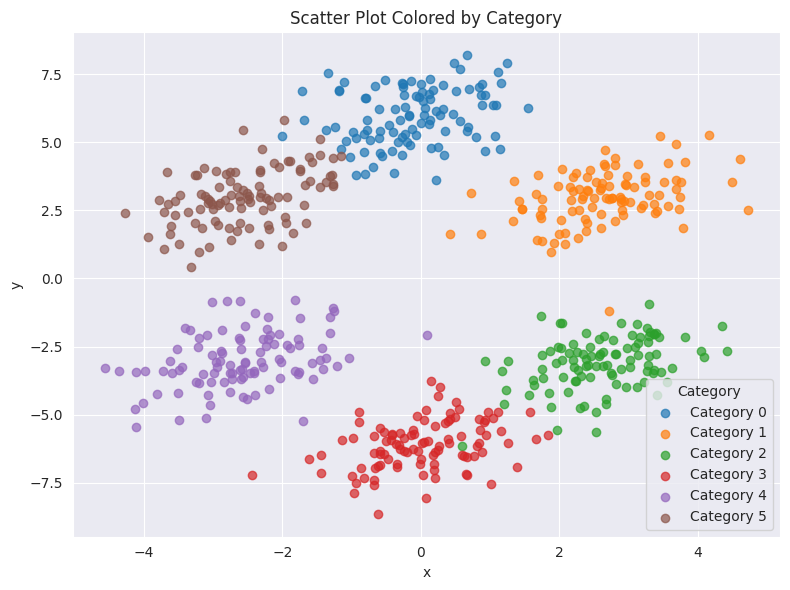

In [18]:
raw = pd.read_csv('../koh_data/hexagon.csv')
labeled = one_hot_encode_last_column(raw)
scatter_with_categories(raw)


In [24]:
unlabeled = labeled[['x', 'y']].values
sigmas = [0.1, 0.3, 0.5, 1, 3, 5, 10]
lambdas = [100, 500, 2500, 10000, 50000, 250000]
neighborhoods = ['gaussian', 'sec_gaussian_der']


100%|██████████| 10000/10000 [00:23<00:00, 425.14it/s]
/tmp/ipykernel_35736/3999024557.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
100%|██████████| 10000/10000 [00:24<00:00, 414.54it/s]


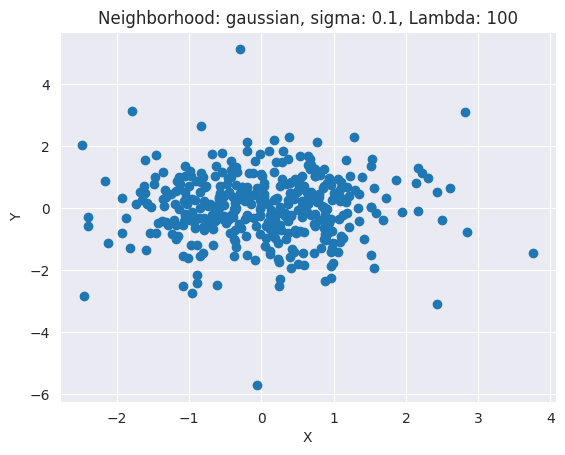

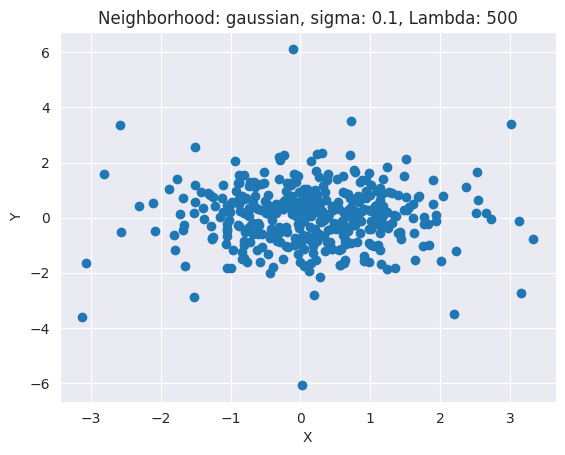

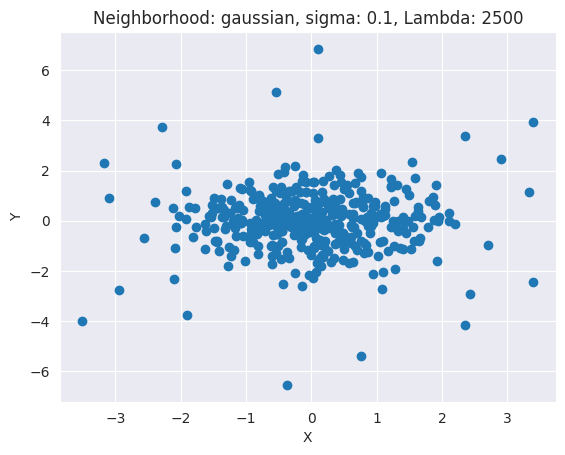

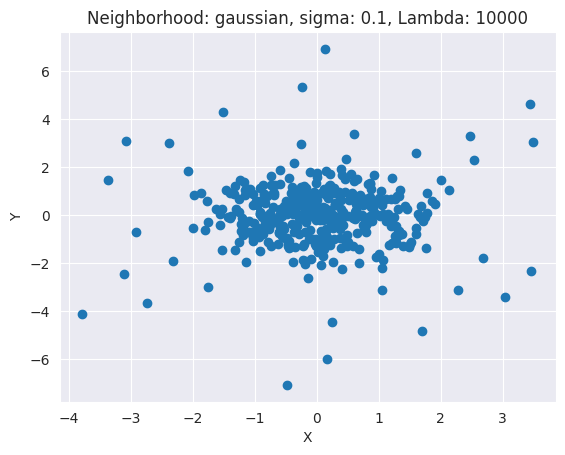

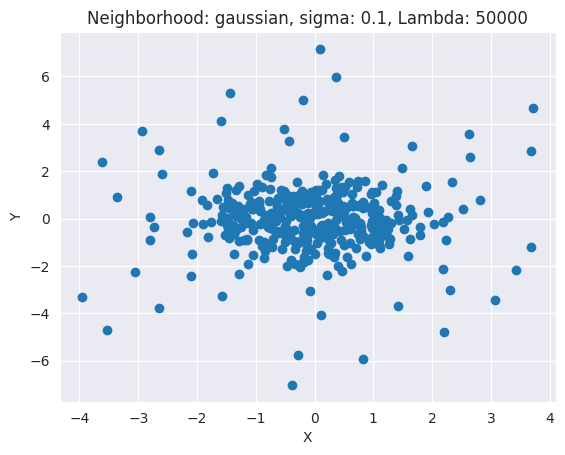

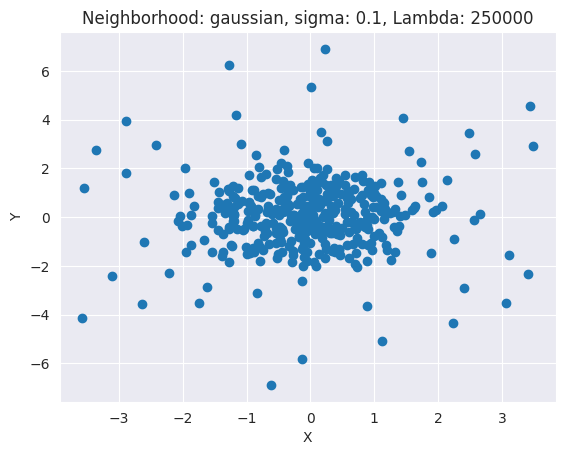

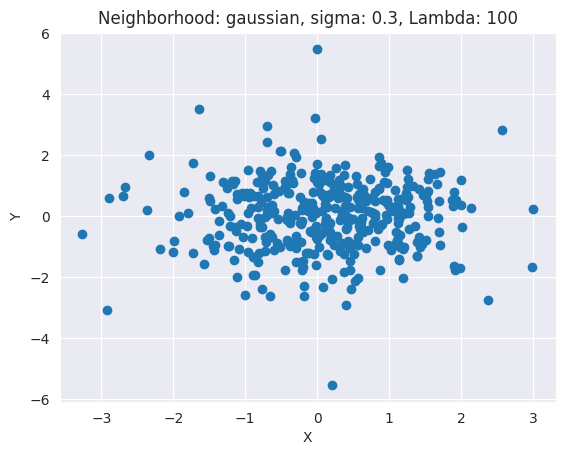

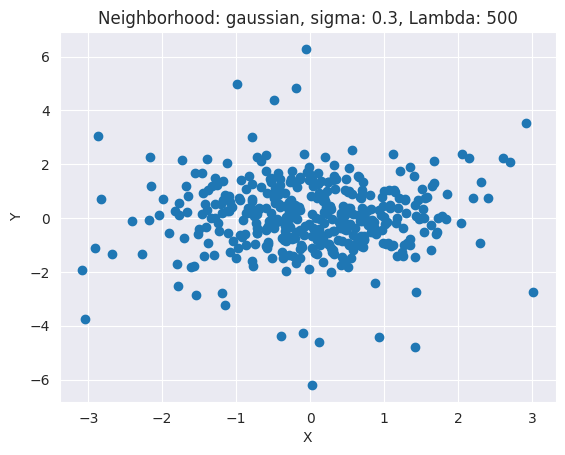

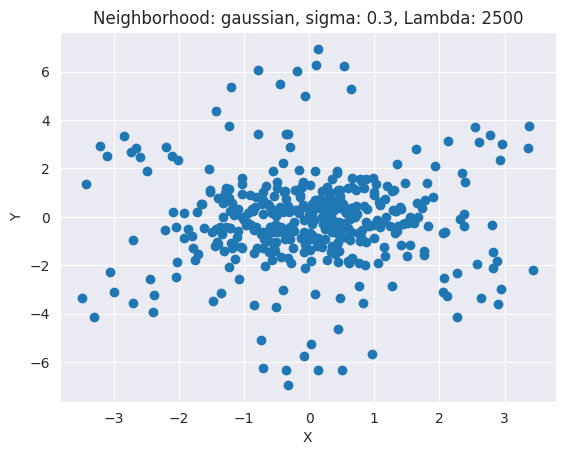

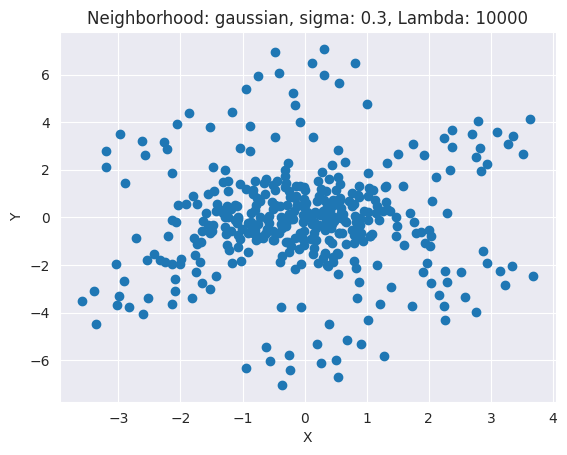

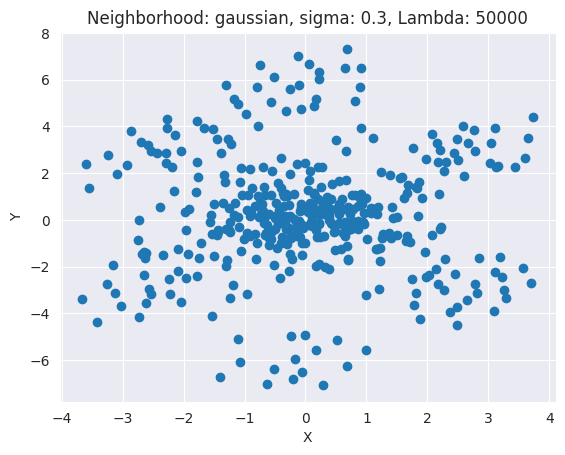

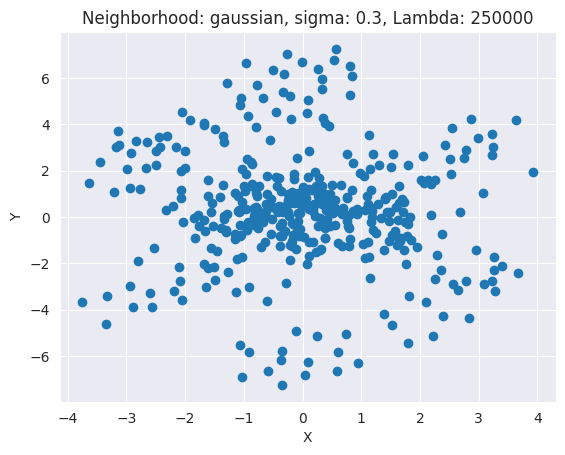

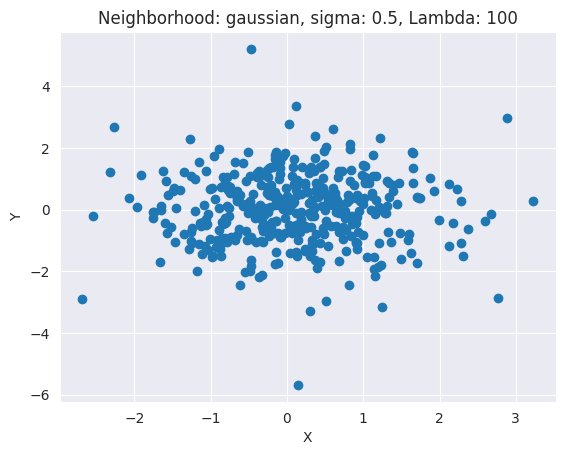

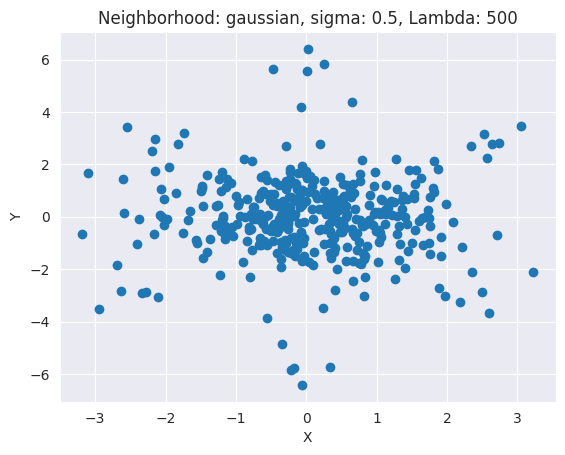

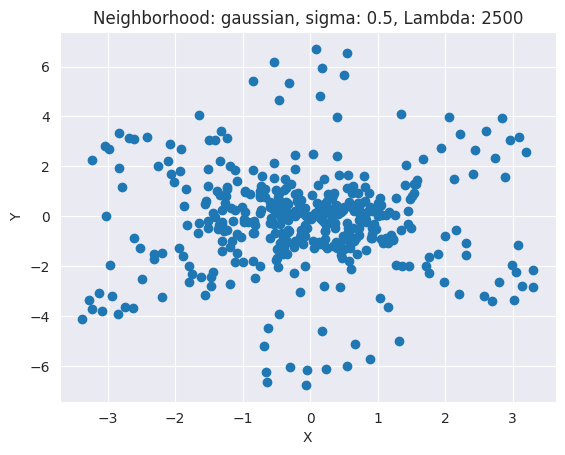

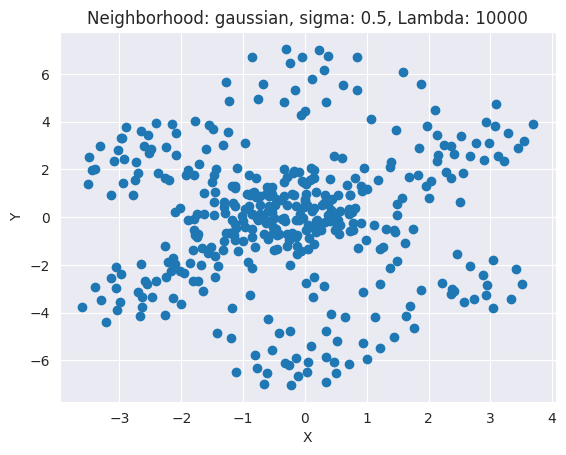

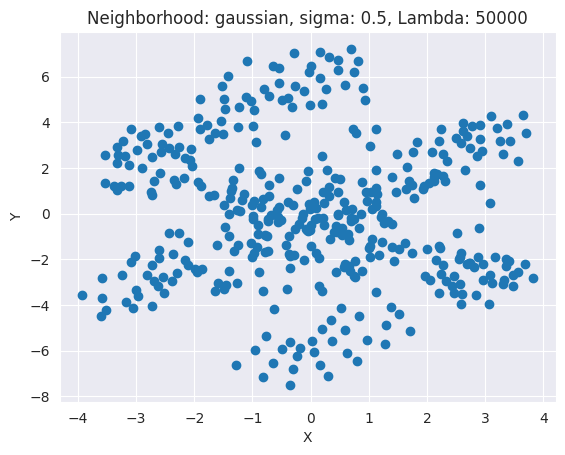

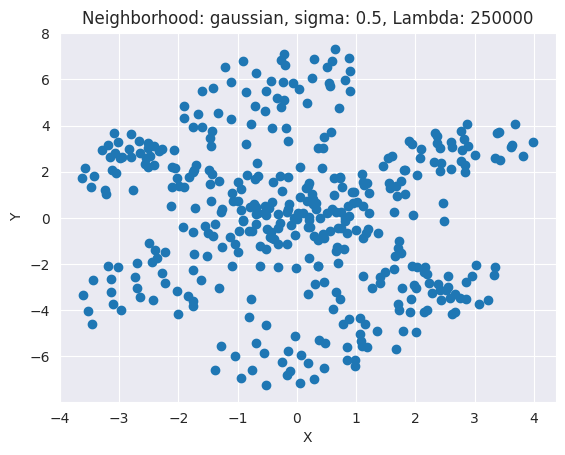

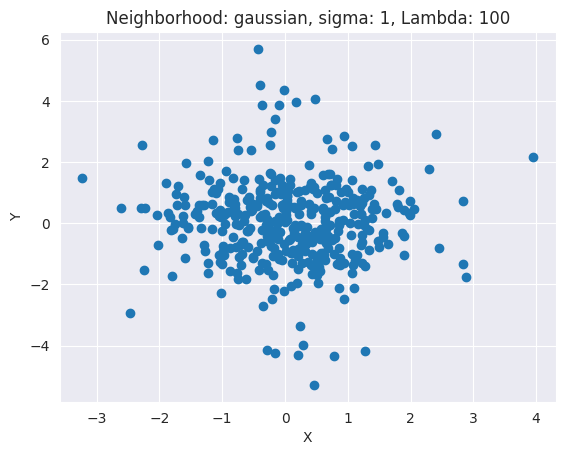

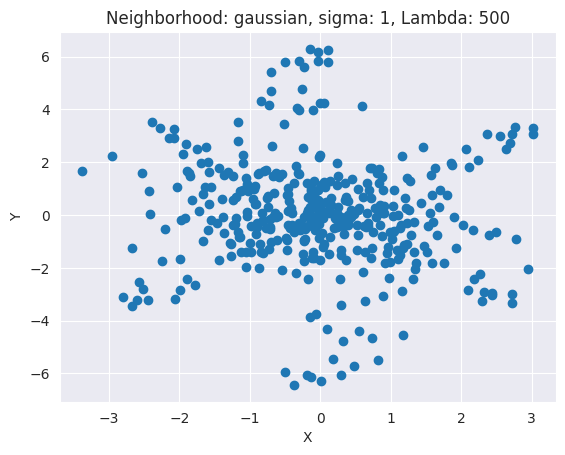

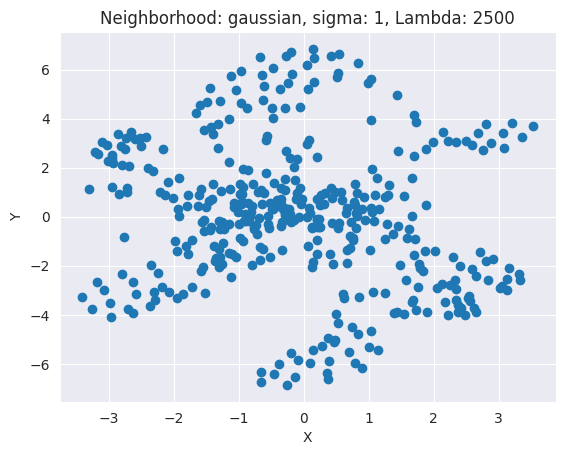

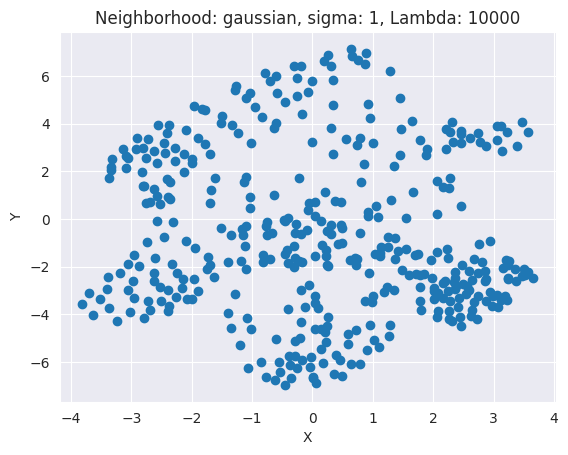

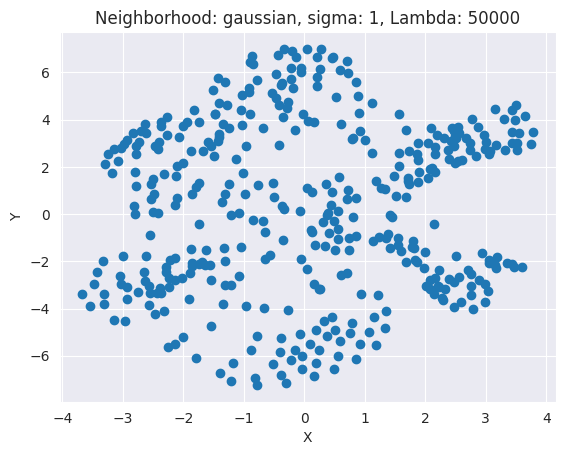

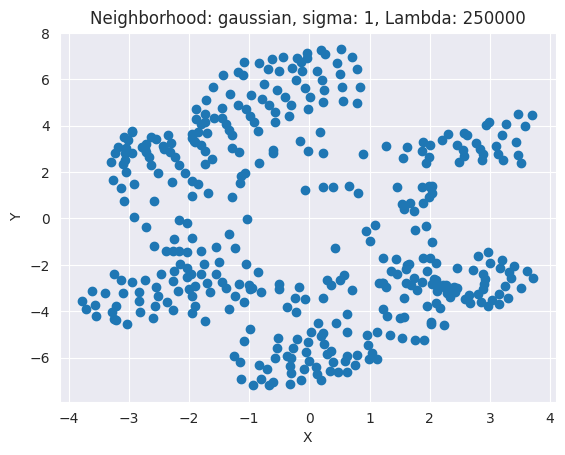

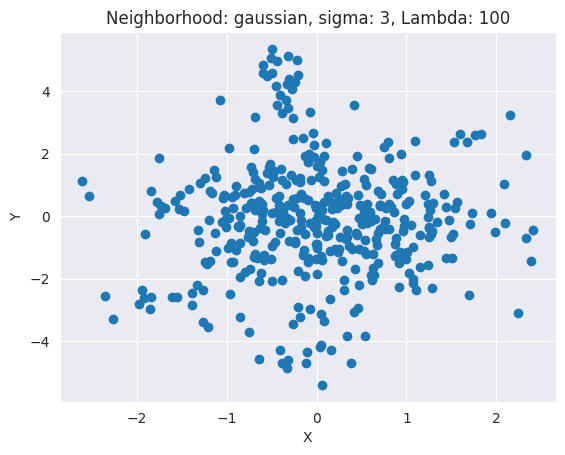

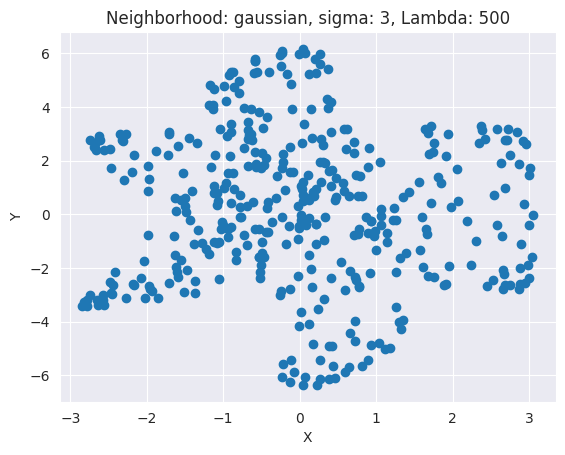

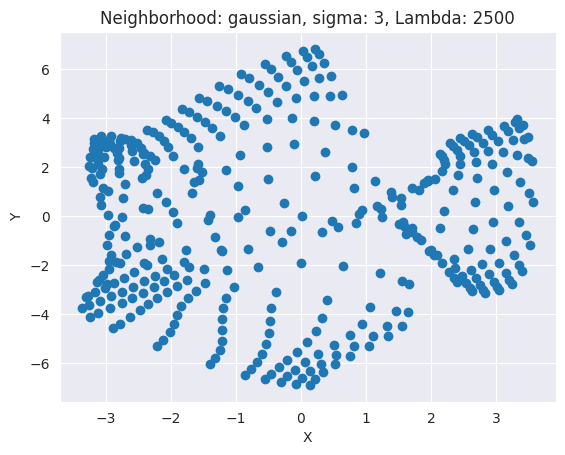

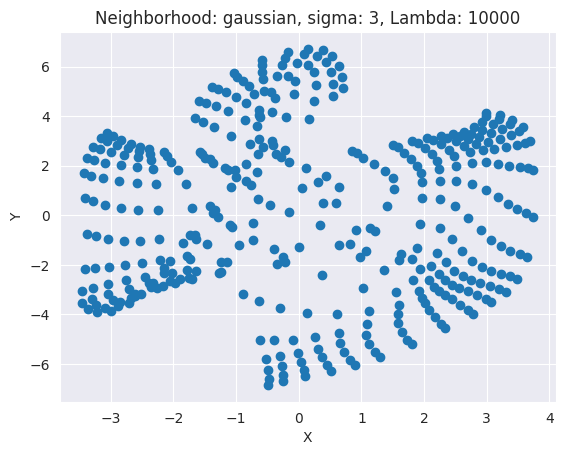

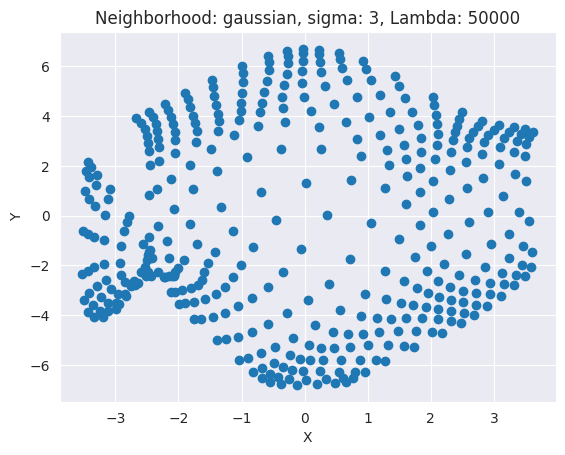

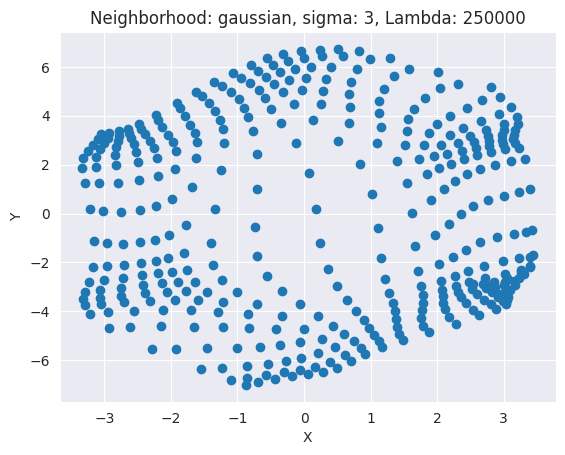

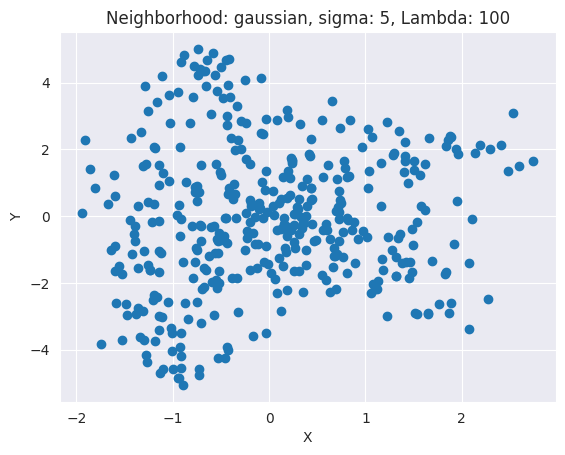

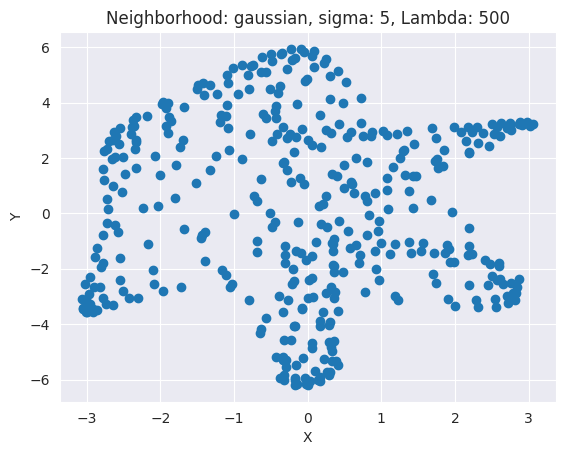

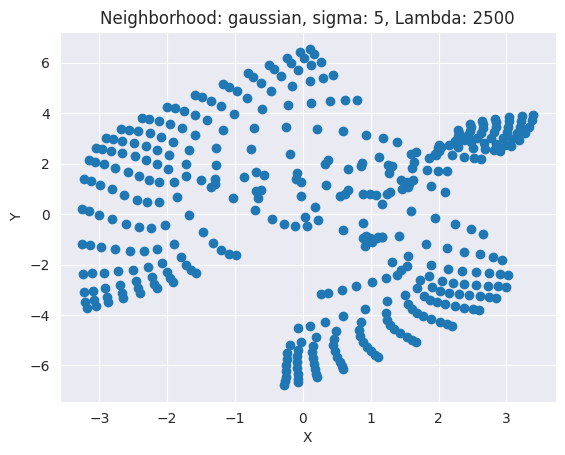

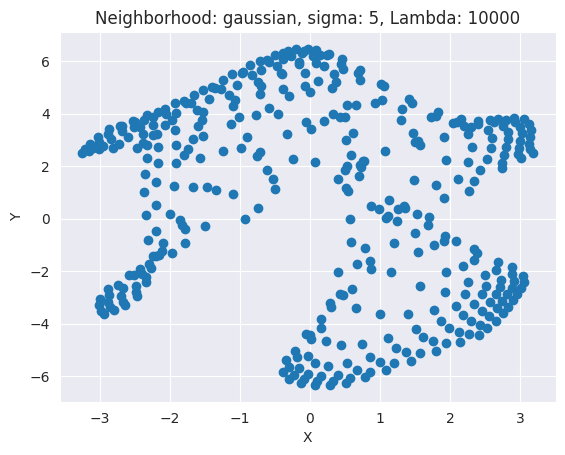

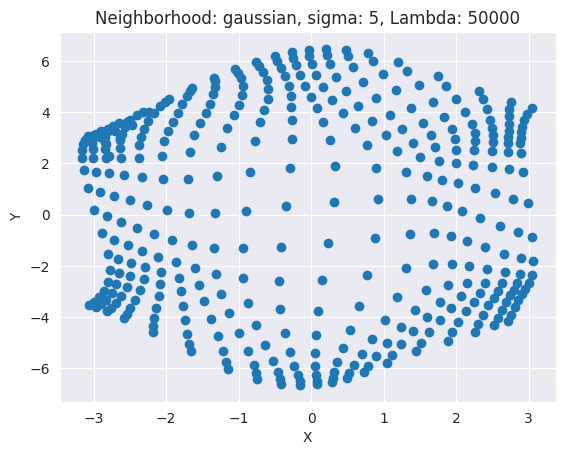

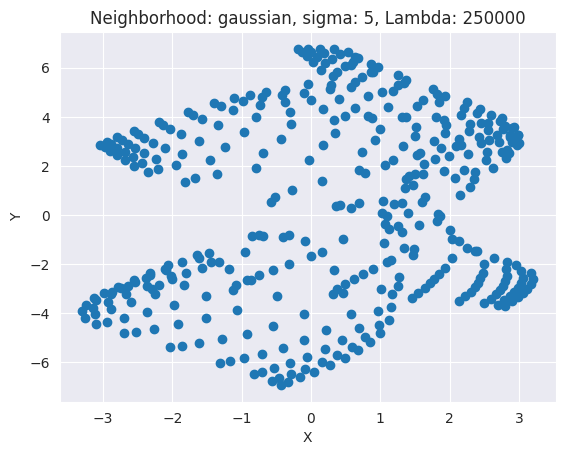

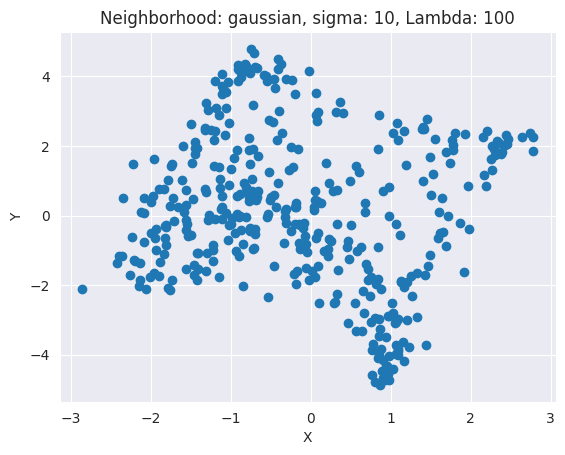

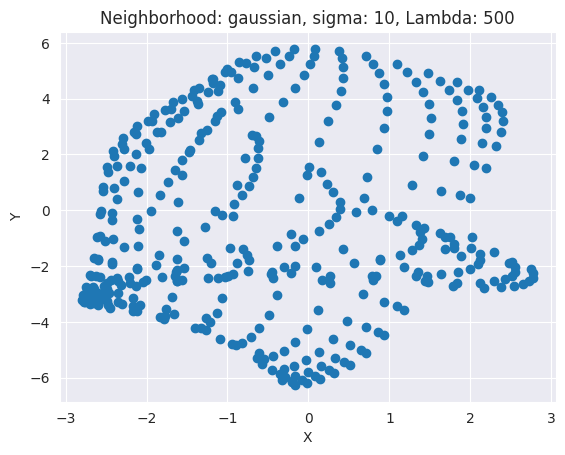

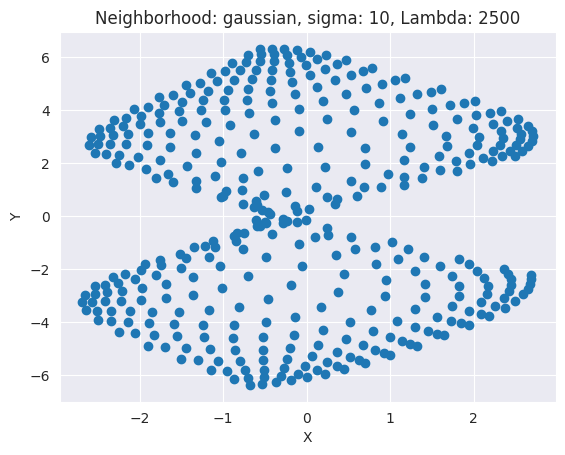

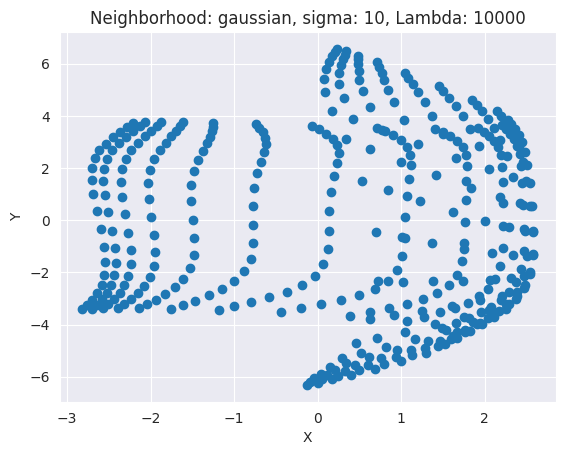

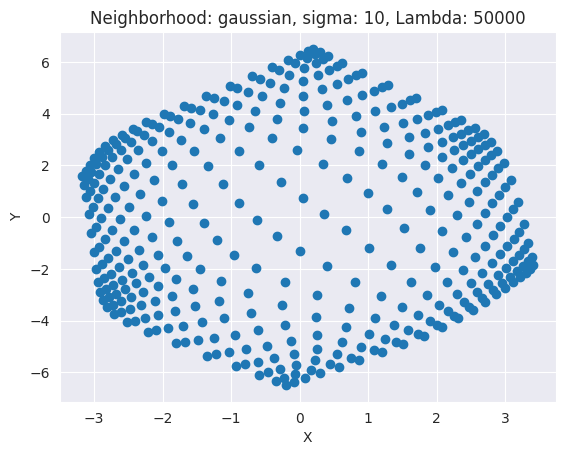

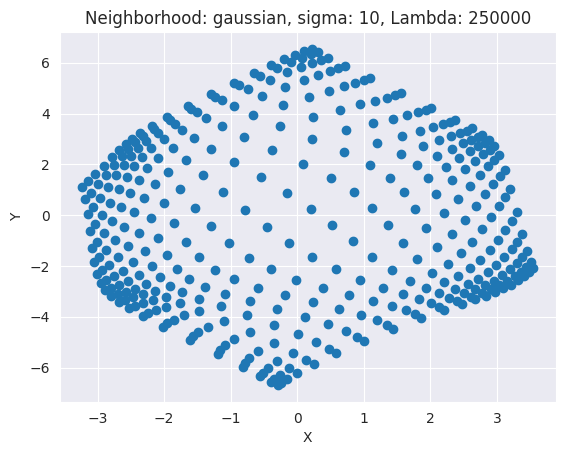

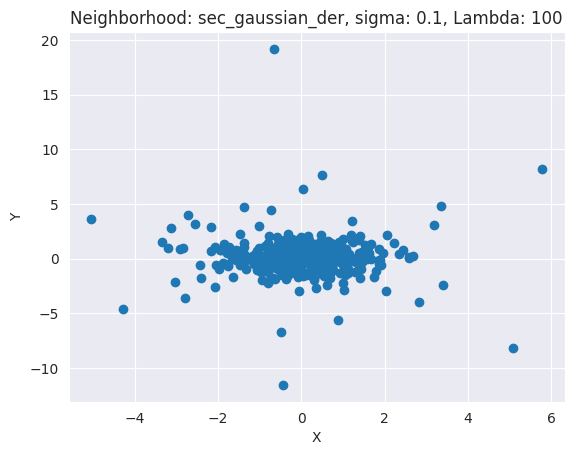

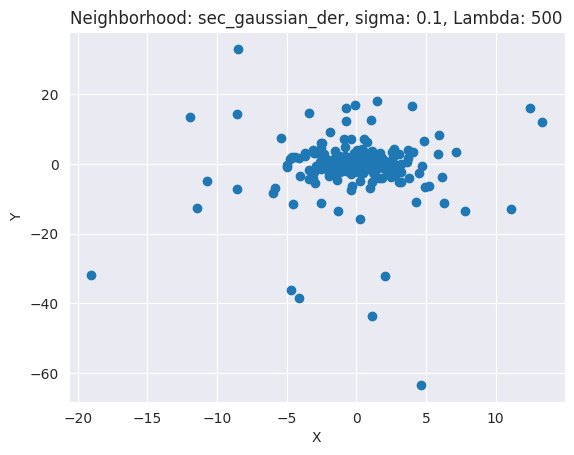

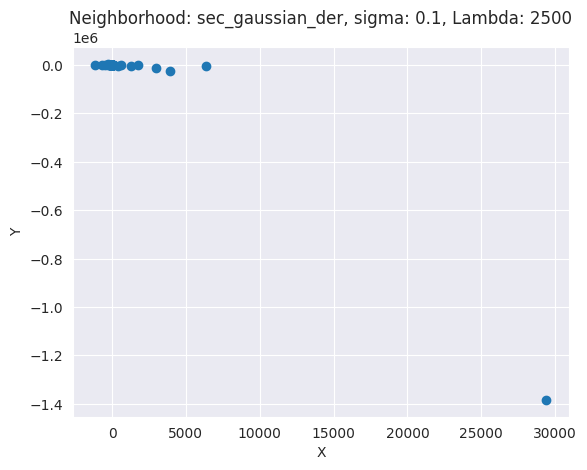

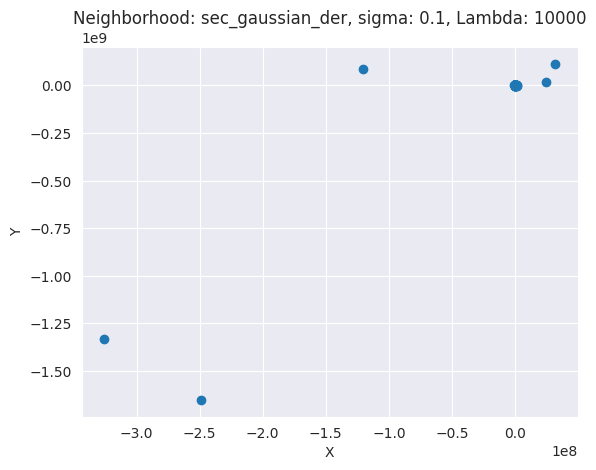

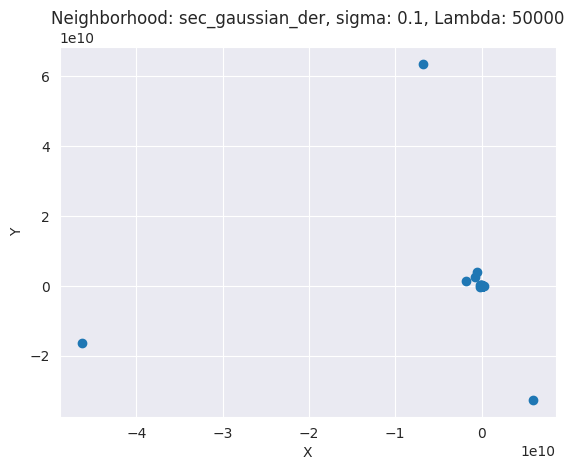

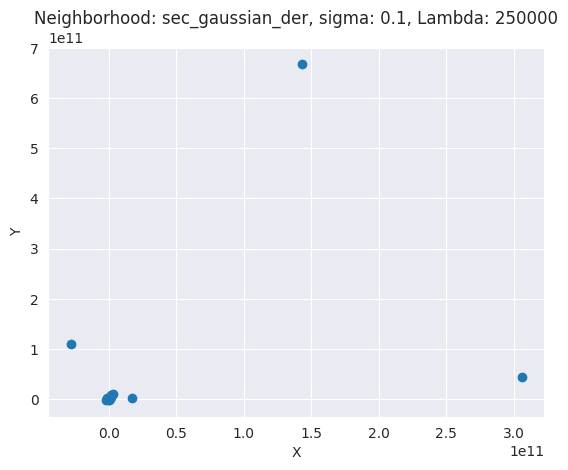

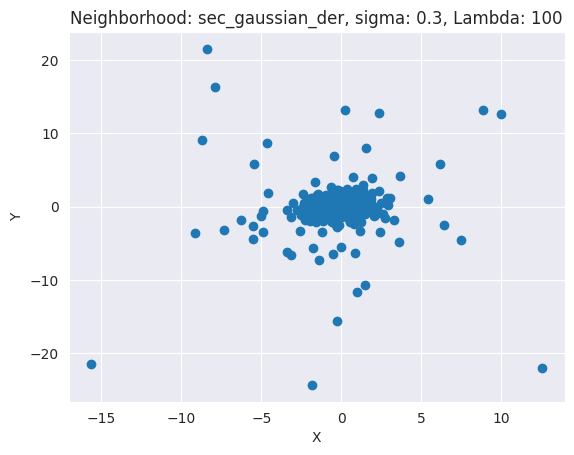

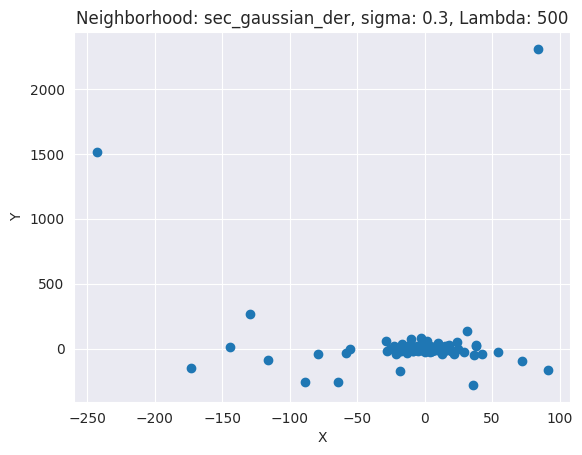

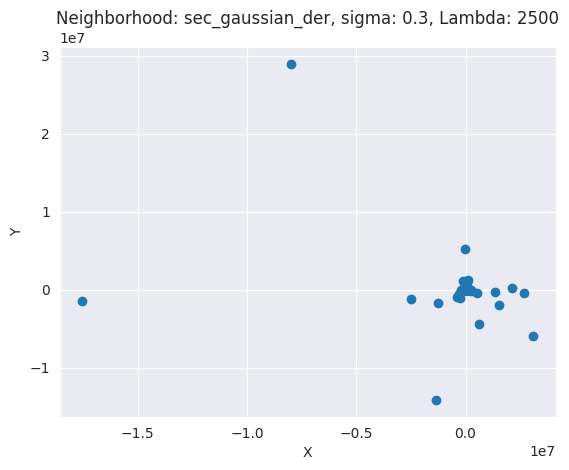

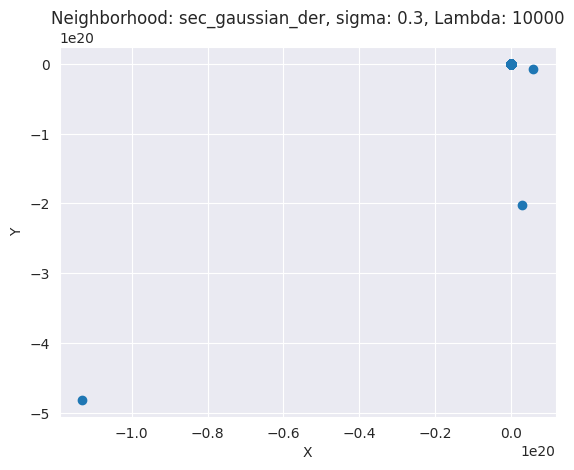

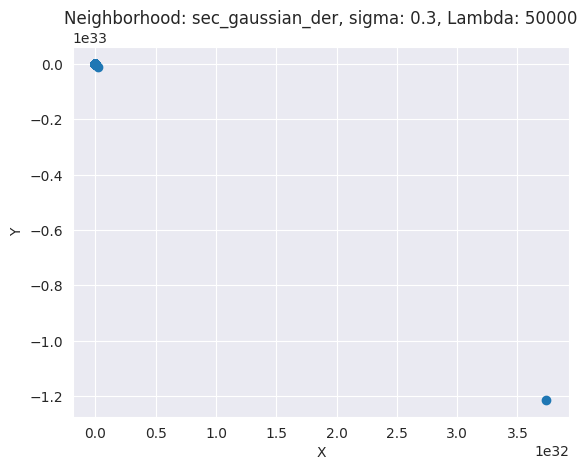

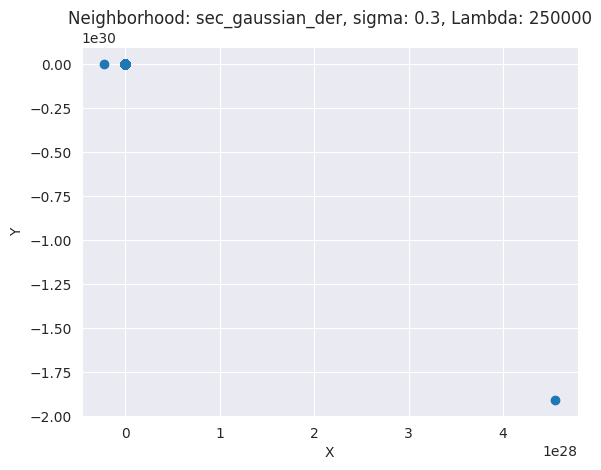

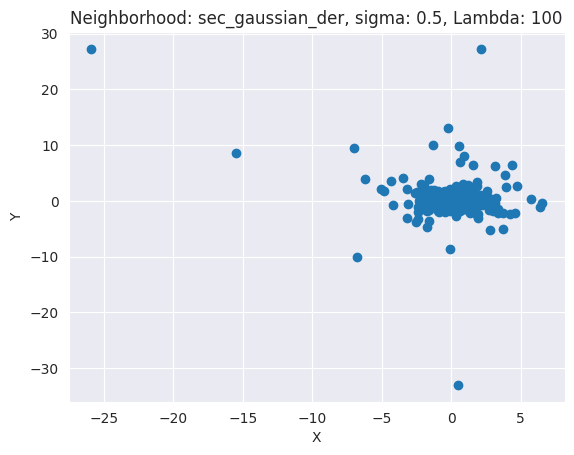

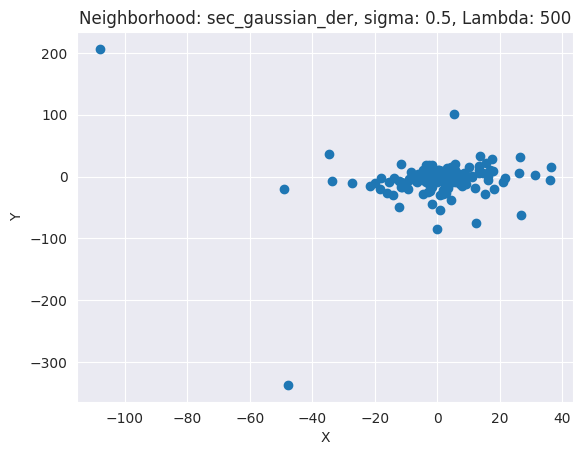

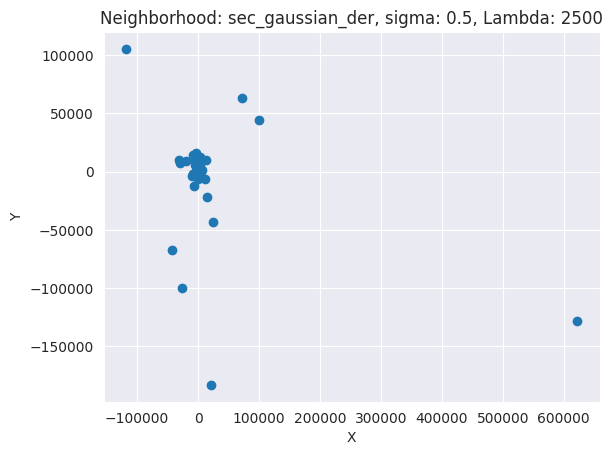

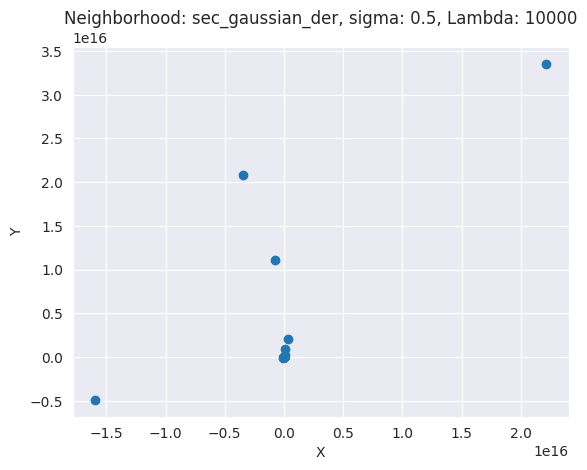

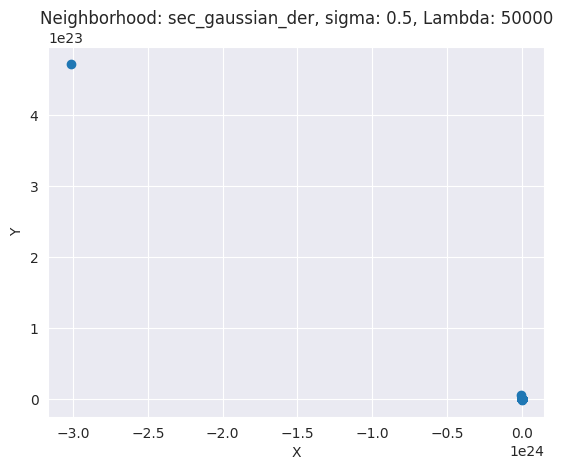

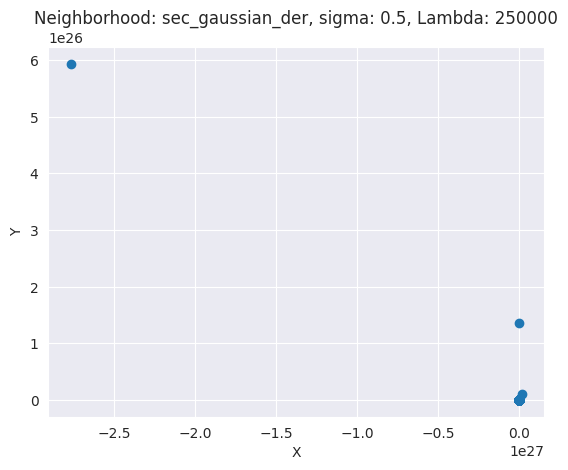

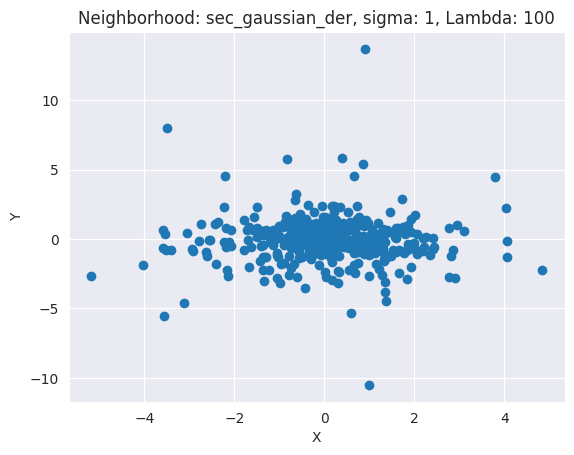

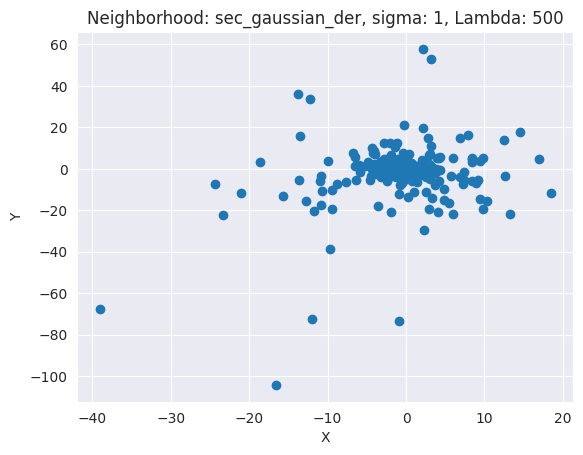

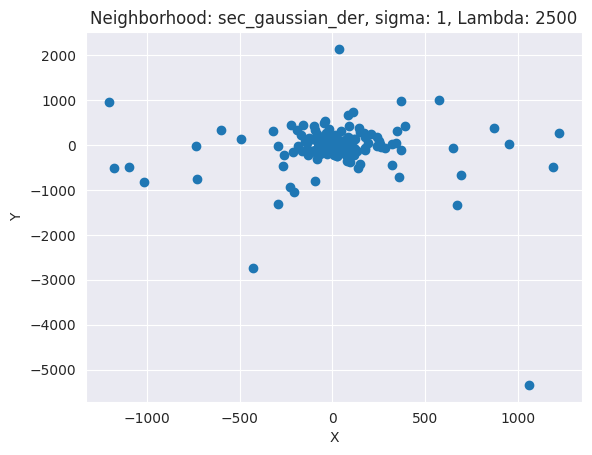

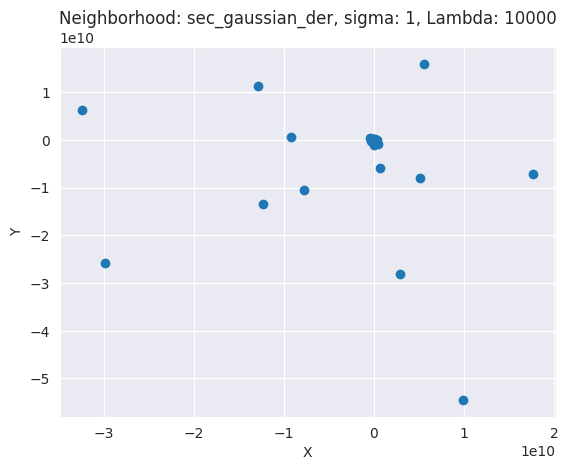

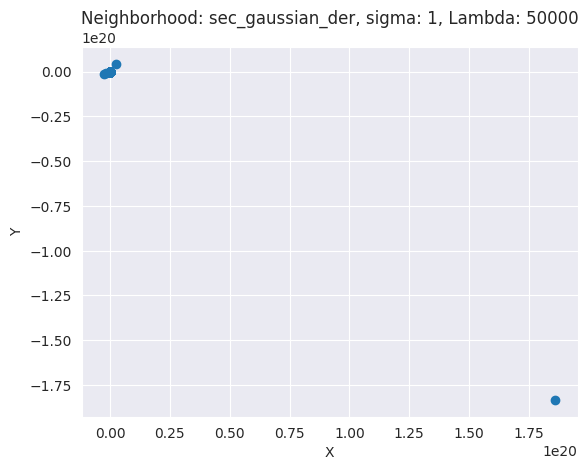

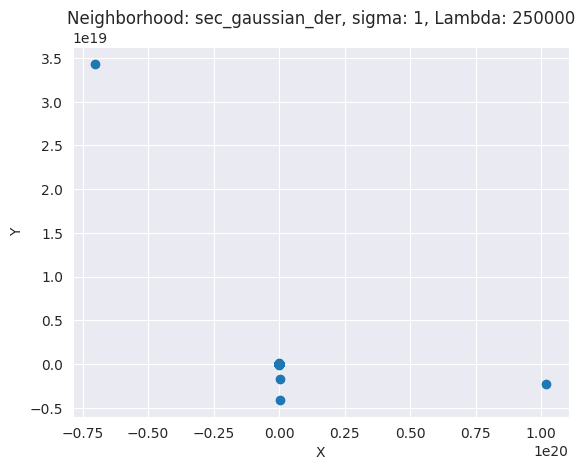

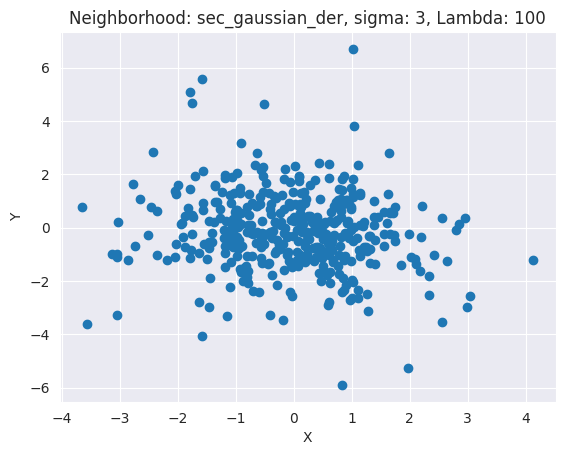

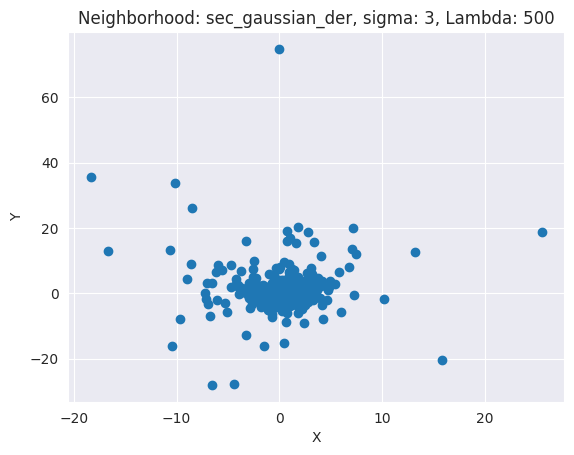

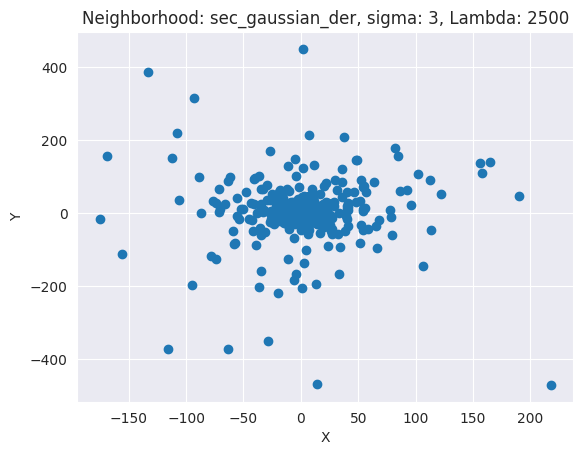

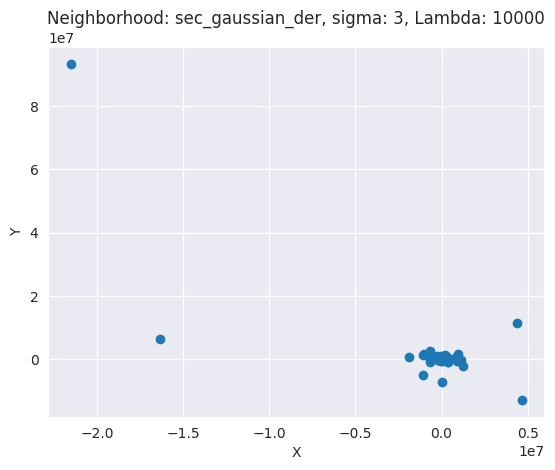

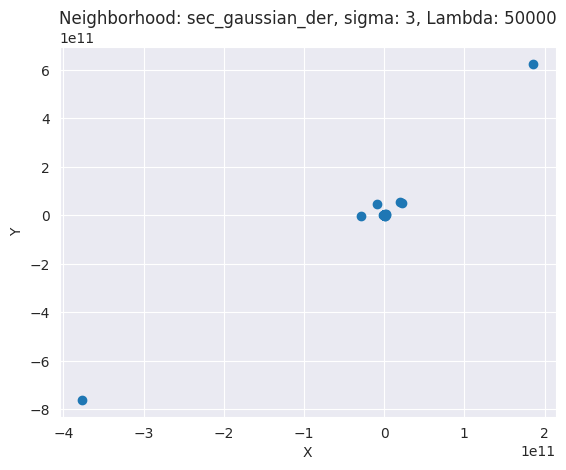

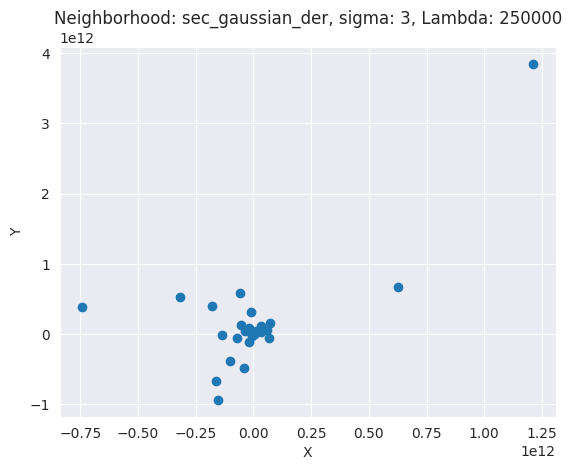

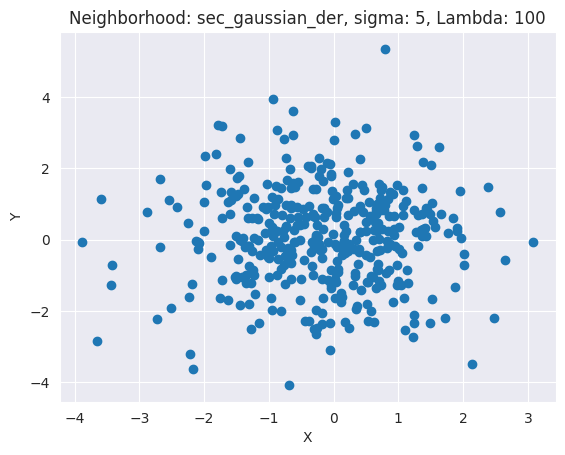

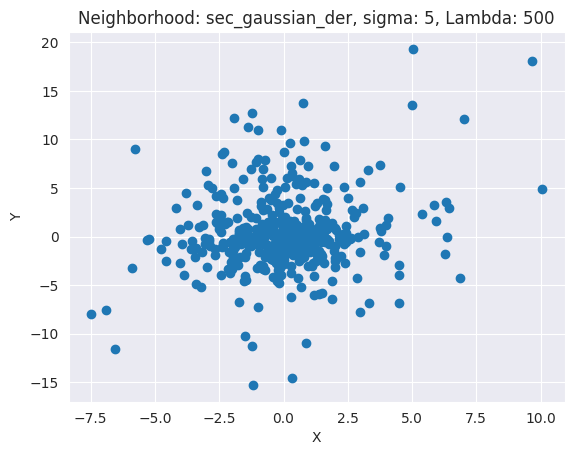

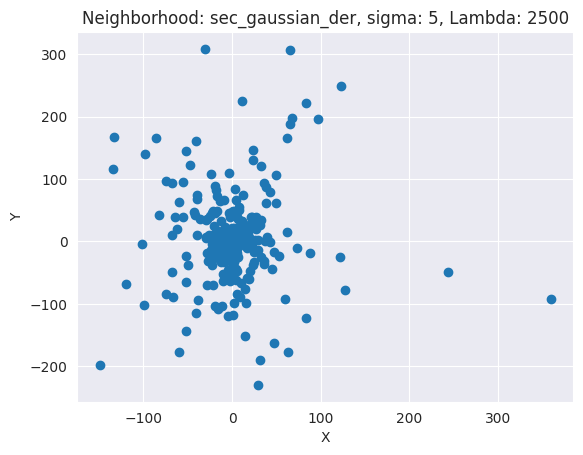

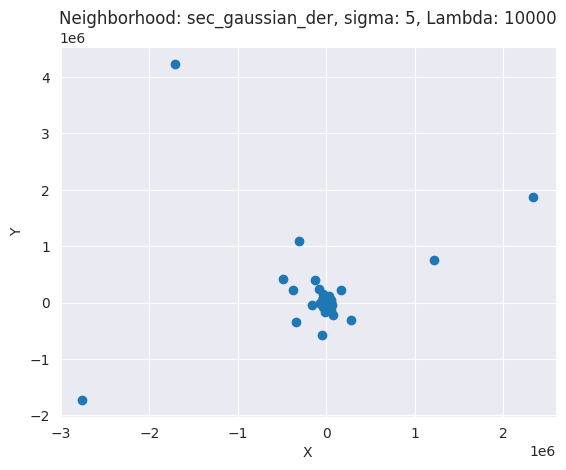

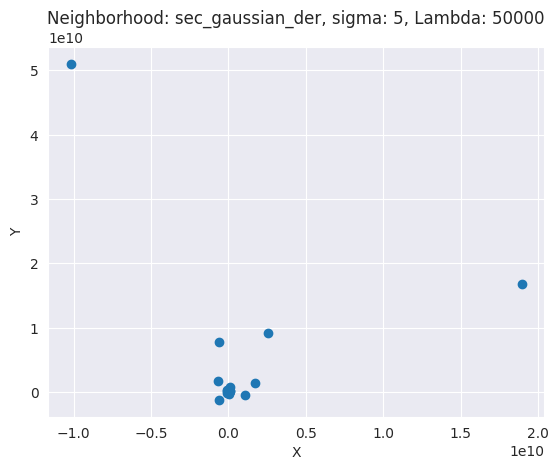

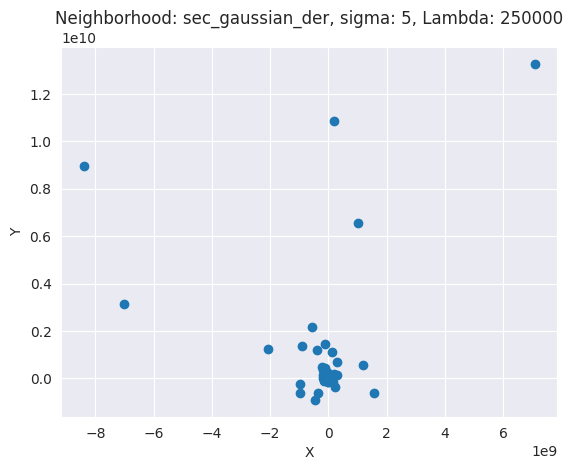

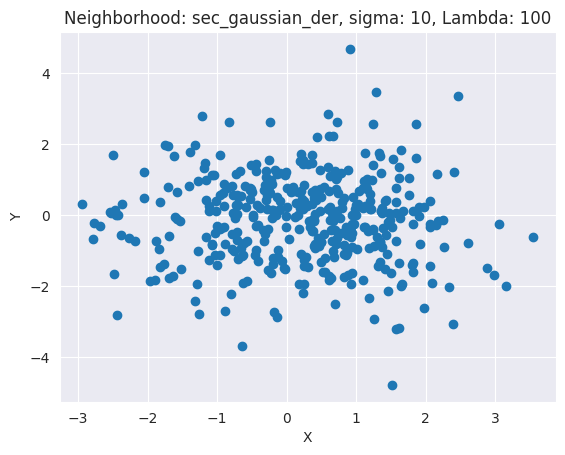

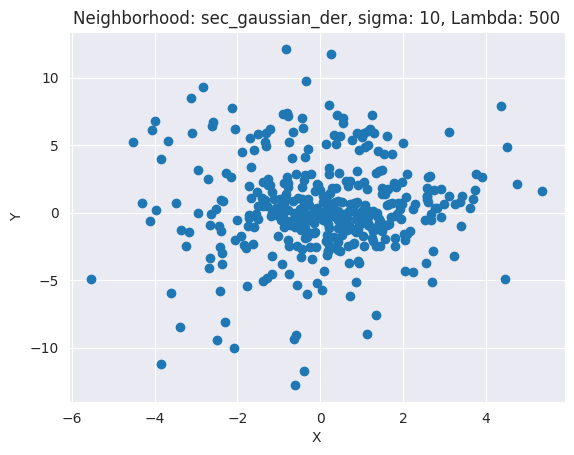

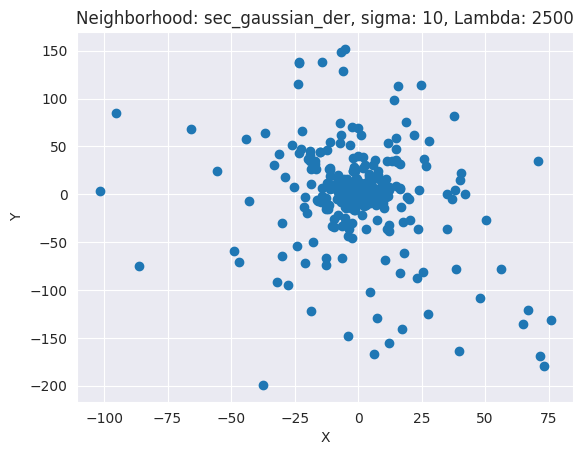

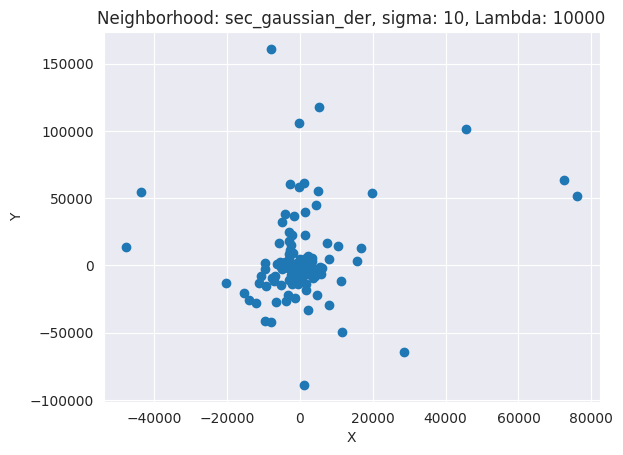

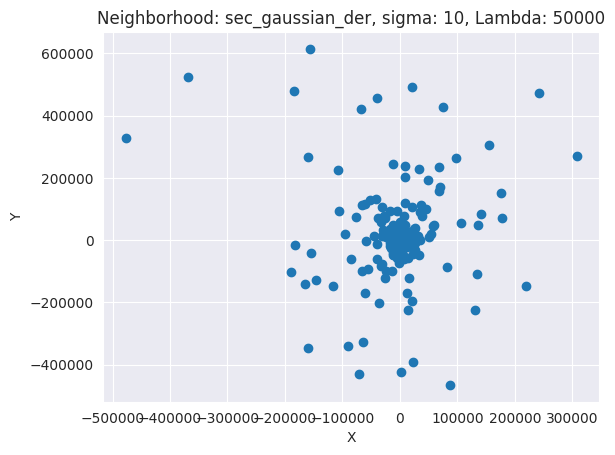

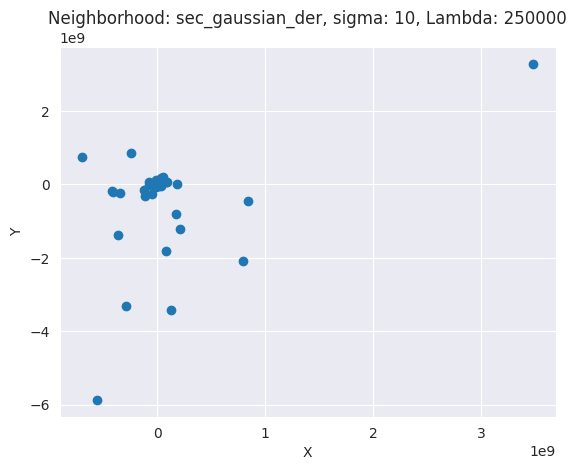

In [25]:
for neighborhood in neighborhoods:
    for sigma in sigmas:
        for lambdaa in lambdas:
            #learn
            network = KohonenNetwork(20, 20)
            network.set_sigma(sigma)
            network.set_neighborhood(neighborhood)
            network.set_lambda(lambdaa)
            network.learn(unlabeled, 10000)
            #extract
            weights = network.weights
            weights = np.array(weights)
            weights = weights.reshape(-1, 2)
            #plot
            plt.figure()
            scatter_or = plt.scatter(weights[:,0], weights[:,1])
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.title(f"Neighborhood: {neighborhood}, sigma: {sigma}, Lambda: {lambdaa}")


# Najlepsze wydają się (sigma=0.3, lambda=10000) oraz (sigma = 10, lambda=10000) (gaussowskie)

# sigma=0.5, lambda=250000

100%|██████████| 10000/10000 [00:26<00:00, 377.98it/s]


Text(0.5, 1.0, 'Neighborhood: gaussian, sigma: 0.3, Lambda: 10000')

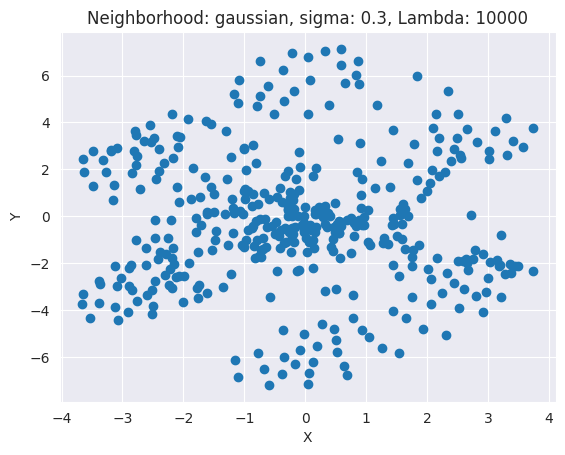

In [27]:
network = KohonenNetwork(20, 20)
network.set_sigma(0.5)
network.set_neighborhood('gaussian')
network.set_lambda(250000)
network.learn(unlabeled, 10000)

weights = network.weights
weights = np.array(weights)
weights = weights.reshape(-1, 2)
#plot
plt.figure()
scatter_or = plt.scatter(weights[:,0], weights[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f"Neighborhood: gaussian, sigma: 0.3, Lambda: 10000")


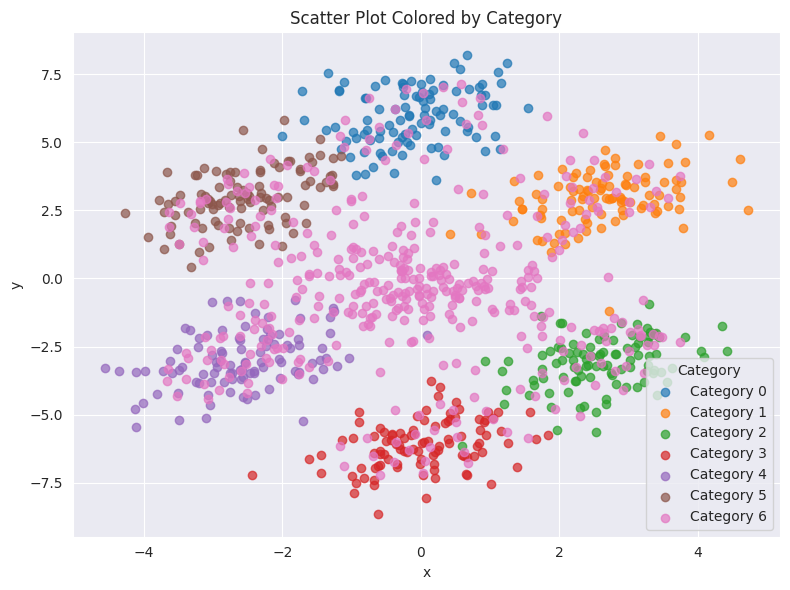

In [28]:
length = weights.shape[0]
third_col = np.array([int(6)]*length)
third_col = third_col.reshape(-1, 1)

weights_newcat = np.hstack((weights, third_col))

new_frame = pd.DataFrame(weights_newcat, columns=['x', 'y', 'c'])
raw_ext = pd.concat([raw, new_frame], axis=0)
raw_ext['c'] = raw_ext['c'].astype(int)
scatter_with_categories(raw_ext)

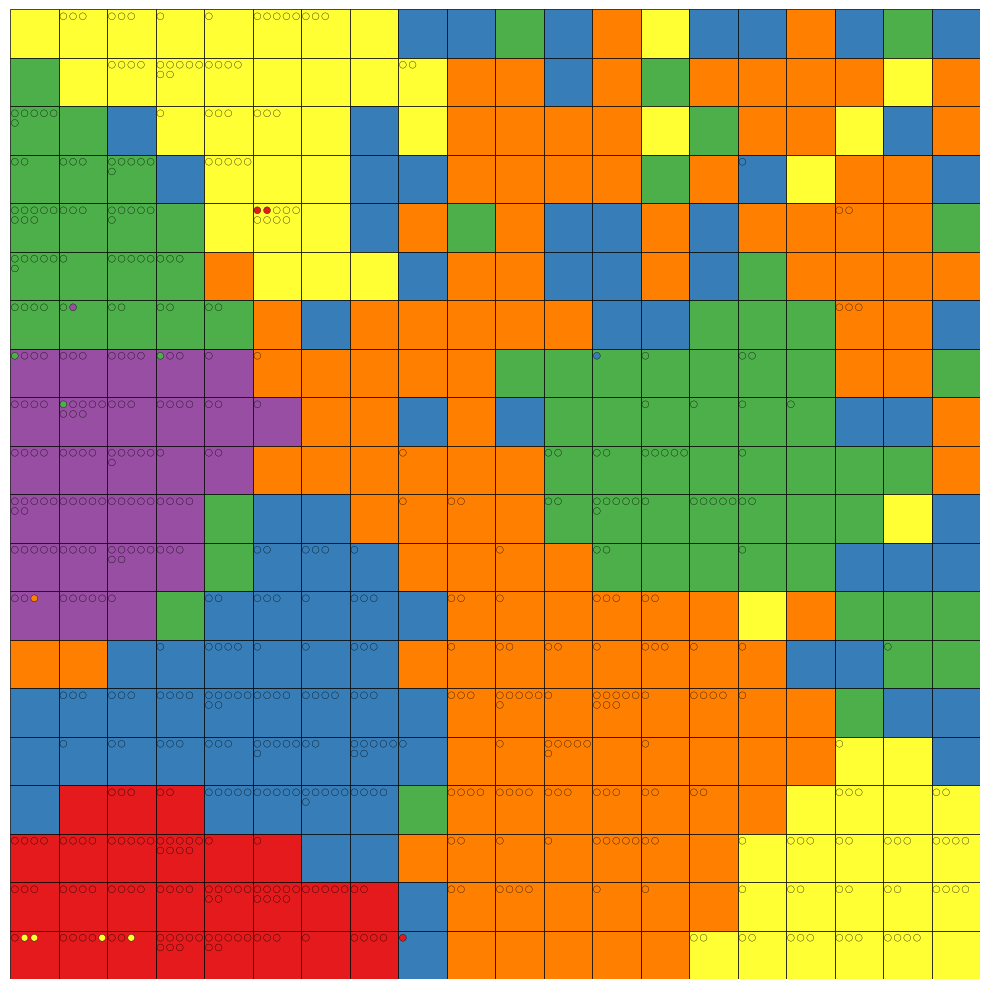

In [29]:
weights = network.weights
for i in range(len(weights)):
    for j in range(len(weights[0])):
        weights[i][j] = list(weights[i][j])

weightsnp = np.array(weights)
weightsnp.shape
data_points = raw.values
closest_data = get_closest_data(weightsnp, data_points)
closest_data2 = get_closest_data_neuron(weightsnp, data_points)
visualise_kohonen(closest_data, closest_data2)

# sigma=1, lambda=250000

100%|██████████| 10000/10000 [00:23<00:00, 426.72it/s]


Text(0.5, 1.0, 'Neighborhood: gaussian, sigma: 10, Lambda: 10000')

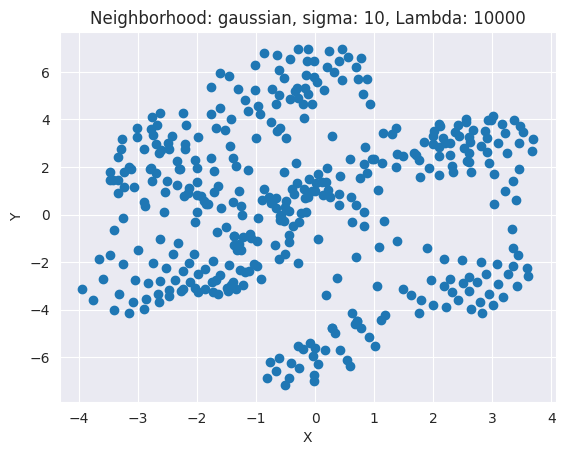

In [30]:

network = KohonenNetwork(20, 20)
network.set_sigma(1)
network.set_neighborhood('gaussian')
network.set_lambda(250000)
network.learn(unlabeled, 10000)

weights = network.weights
weights = np.array(weights)
weights = weights.reshape(-1, 2)
#plot
plt.figure()
scatter_or = plt.scatter(weights[:, 0], weights[:, 1])
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f"Neighborhood: gaussian, sigma: 10, Lambda: 10000")

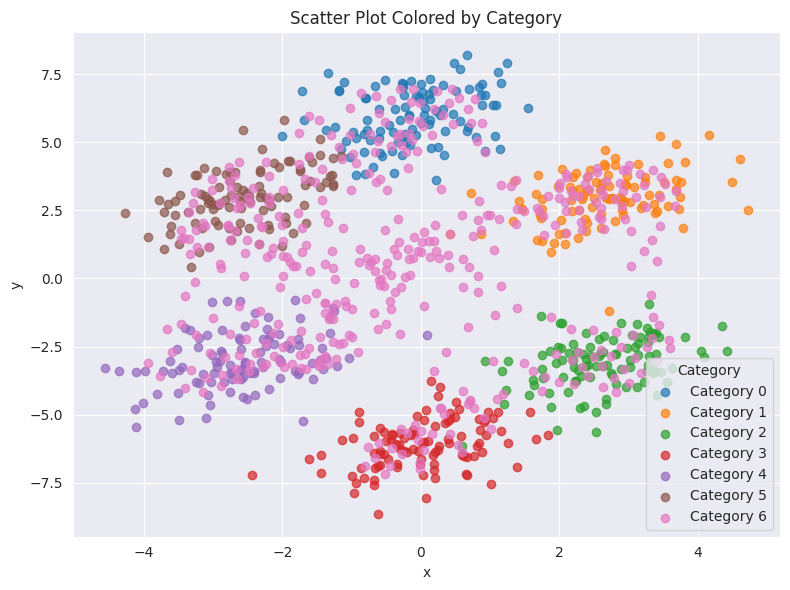

In [31]:
length = weights.shape[0]
third_col = np.array([int(6)]*length)
third_col = third_col.reshape(-1, 1)

weights_newcat = np.hstack((weights, third_col))

new_frame = pd.DataFrame(weights_newcat, columns=['x', 'y', 'c'])
raw_ext = pd.concat([raw, new_frame], axis=0)
raw_ext['c'] = raw_ext['c'].astype(int)
scatter_with_categories(raw_ext)


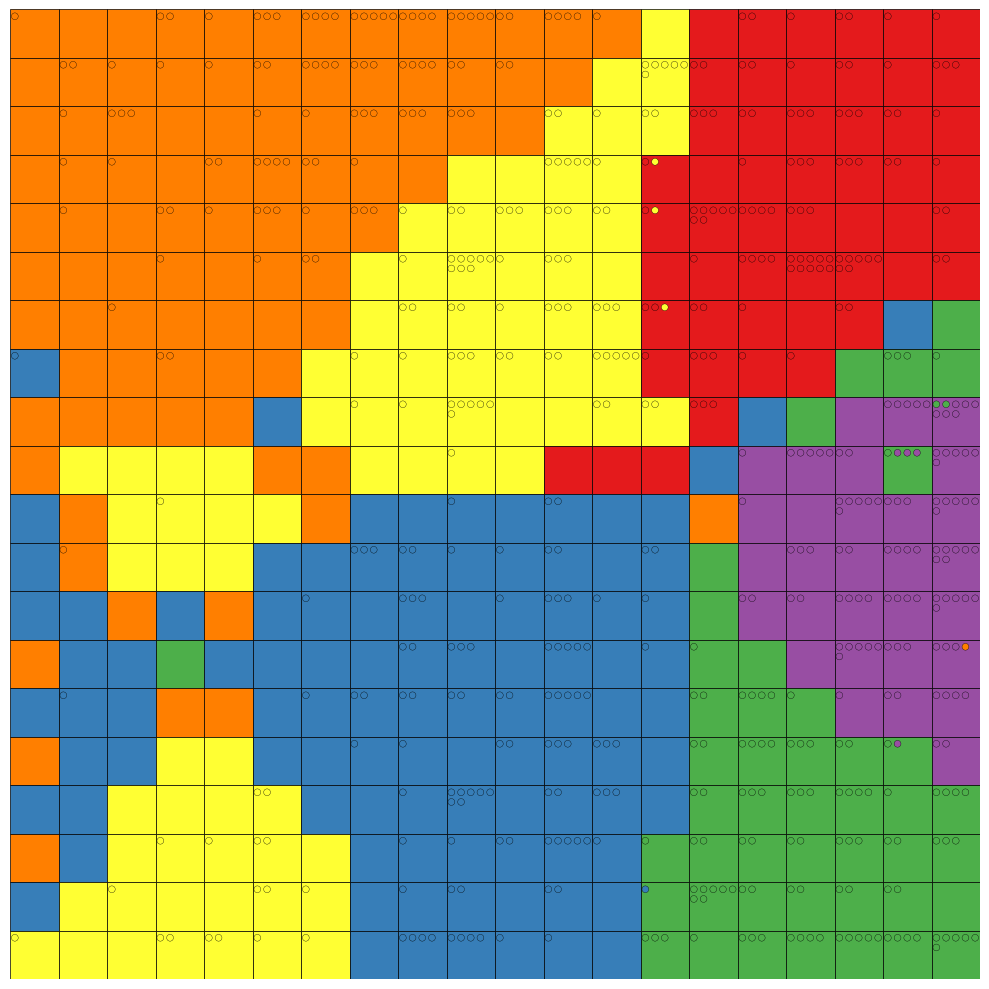

In [32]:
weights = network.weights
for i in range(len(weights)):
    for j in range(len(weights[0])):
        weights[i][j] = list(weights[i][j])

weightsnp = np.array(weights)
weightsnp.shape
data_points = raw.values
closest_data = get_closest_data(weightsnp, data_points)
closest_data2 = get_closest_data_neuron(weightsnp, data_points)
visualise_kohonen(closest_data, closest_data2)

# $\sigma=10$ $\lambda=250000$

100%|██████████| 10000/10000 [00:24<00:00, 414.42it/s]


Text(0.5, 1.0, 'Neighborhood: gaussian, sigma: 10, Lambda: 10000')

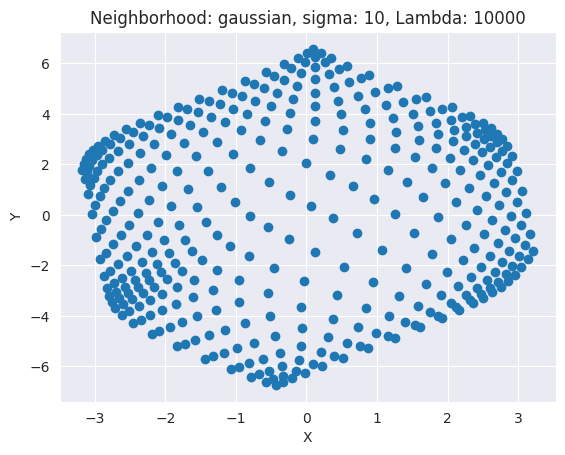

In [33]:
network = KohonenNetwork(20, 20)
network.set_sigma(10)
network.set_neighborhood('gaussian')
network.set_lambda(250000)
network.learn(unlabeled, 10000)

weights = network.weights
weights = np.array(weights)
weights = weights.reshape(-1, 2)
#plot
plt.figure()
scatter_or = plt.scatter(weights[:, 0], weights[:, 1])
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f"Neighborhood: gaussian, sigma: 10, Lambda: 10000")

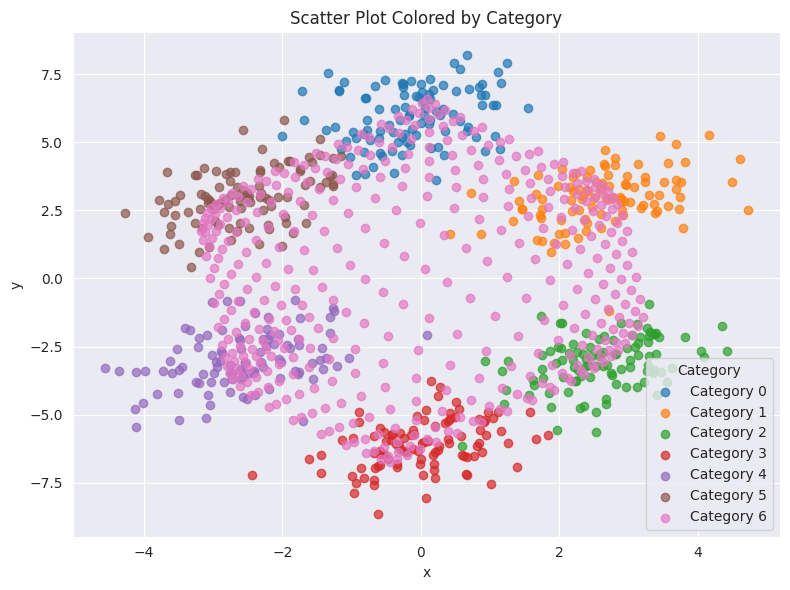

In [34]:
length = weights.shape[0]
third_col = np.array([int(6)]*length)
third_col = third_col.reshape(-1, 1)

weights_newcat = np.hstack((weights, third_col))

new_frame = pd.DataFrame(weights_newcat, columns=['x', 'y', 'c'])
raw_ext = pd.concat([raw, new_frame], axis=0)
raw_ext['c'] = raw_ext['c'].astype(int)
scatter_with_categories(raw_ext)

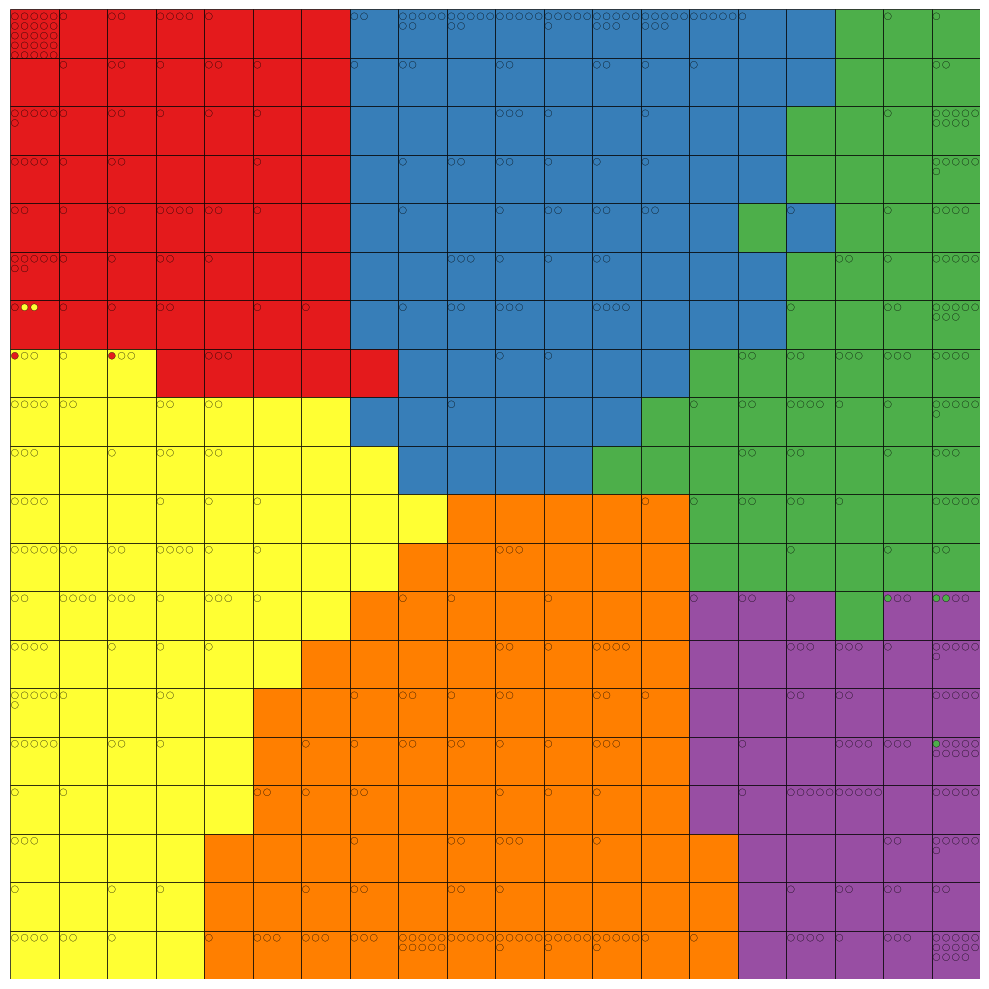

In [35]:
weights = network.weights
for i in range(len(weights)):
    for j in range(len(weights[0])):
        weights[i][j] = list(weights[i][j])

weightsnp = np.array(weights)
weightsnp.shape
data_points = raw.values
closest_data = get_closest_data(weightsnp, data_points)
closest_data2 = get_closest_data_neuron(weightsnp, data_points)
visualise_kohonen(closest_data, closest_data2)

# SZEŚĆ KLASTRÓW AUUUUUUUU